## **1. BUSINESS UNDERSTANDING**

**Goal:** Using survey data to understand and predict developer salaries.

**Why it matters:** This can help recruiters make fair salary offers and help developers negotiate better based on their profile.

## **2.** **DATA** **LOADING**

In [12]:
# -------------------------------
# 1. Data Loading
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv("survey_results_public.csv")

# Select relevant columns
eda_columns = [
    'Age', 'EdLevel', 'Employment', 'RemoteWork',
    'ConvertedCompYearly', 'JobSat', 'YearsCodePro', 'LanguageHaveWorkedWith'
]
eda_df = df[eda_columns].copy()


## **3. EXPLORATORY DATA ANALYSIS (EDA)**

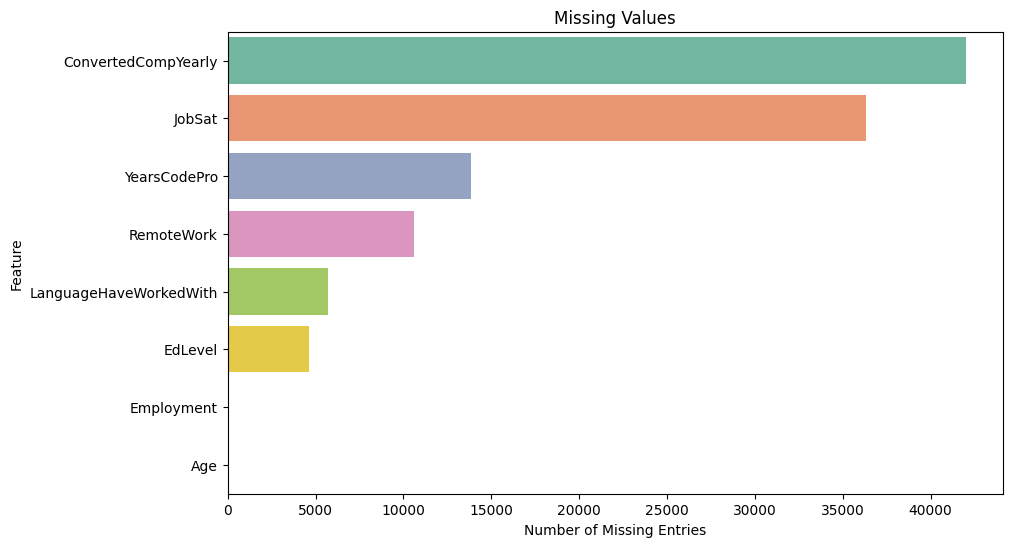

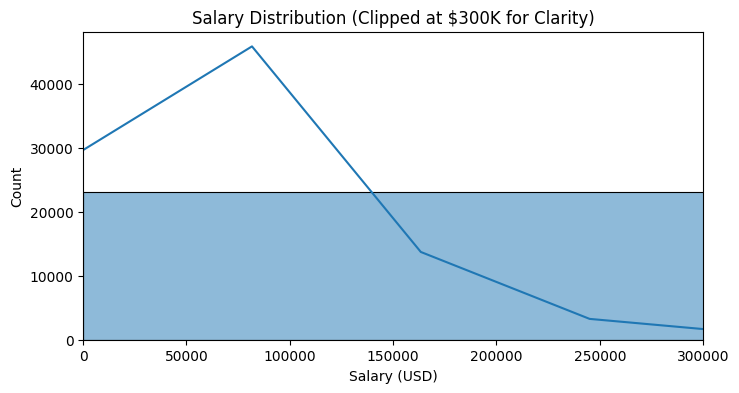

In [13]:
# -------------------------------
# 2. Exploratory Data Analysis (EDA)
# -------------------------------
# Check for missing values
missing = eda_df.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns = ['Feature', 'MissingCount']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=missing,
    x='MissingCount',
    y='Feature',
    hue='Feature',
    palette=sns.color_palette("Set2", n_colors=len(missing)),
    legend=False
)
plt.title("Missing Values")
plt.xlabel("Number of Missing Entries")
plt.ylabel("Feature")
plt.show()

# Visualize salary distribution
plt.figure(figsize=(8, 4))
sns.histplot(eda_df['ConvertedCompYearly'], bins=50, kde=True)
plt.xlim(0, 300000)
plt.title("Salary Distribution (Clipped at $300K for Clarity)")
plt.xlabel("Salary (USD)")
plt.show()


**Summary of Findings:**

* Salary (ConvertedCompYearly) is right-skewed → typical of income data.

* Many missing values in key features like JobSat, YearsCodePro, and LanguageHaveWorkedWith.

* YearsCodePro is not in numeric format (contains "Less than 1 year", etc.).

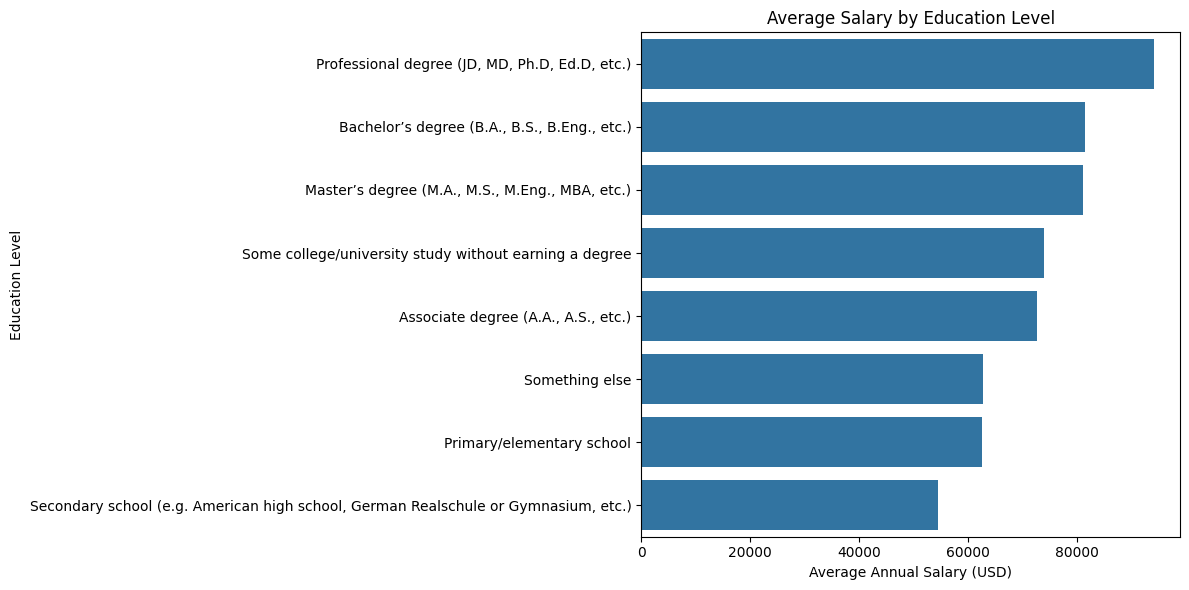

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data
edu_salary = df[['EdLevel', 'ConvertedCompYearly']].dropna()
edu_salary = edu_salary[edu_salary['ConvertedCompYearly'] < 500000]

# Group by education level and calculate mean salary
edu_avg_salary = edu_salary.groupby('EdLevel')['ConvertedCompYearly'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=edu_avg_salary.values, y=edu_avg_salary.index)
plt.title('Average Salary by Education Level')
plt.xlabel('Average Annual Salary (USD)')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()


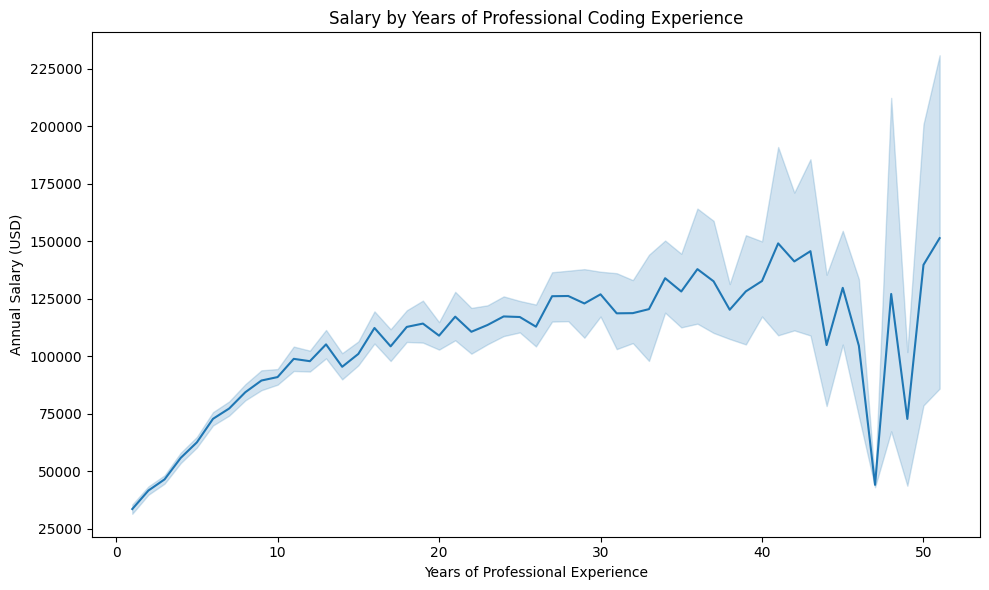

In [15]:
exp_salary = df[['YearsCodePro', 'ConvertedCompYearly']].dropna()
exp_salary = exp_salary[exp_salary['ConvertedCompYearly'] < 500000]
exp_salary = exp_salary[exp_salary['YearsCodePro'] != 'Less than 1 year']
exp_salary['YearsCodePro'] = exp_salary['YearsCodePro'].replace('More than 50 years', '51')
exp_salary['YearsCodePro'] = pd.to_numeric(exp_salary['YearsCodePro'])

plt.figure(figsize=(10,6))
sns.lineplot(data=exp_salary, x='YearsCodePro', y='ConvertedCompYearly')
plt.title('Salary by Years of Professional Coding Experience')
plt.xlabel('Years of Professional Experience')
plt.ylabel('Annual Salary (USD)')
plt.tight_layout()
plt.show()


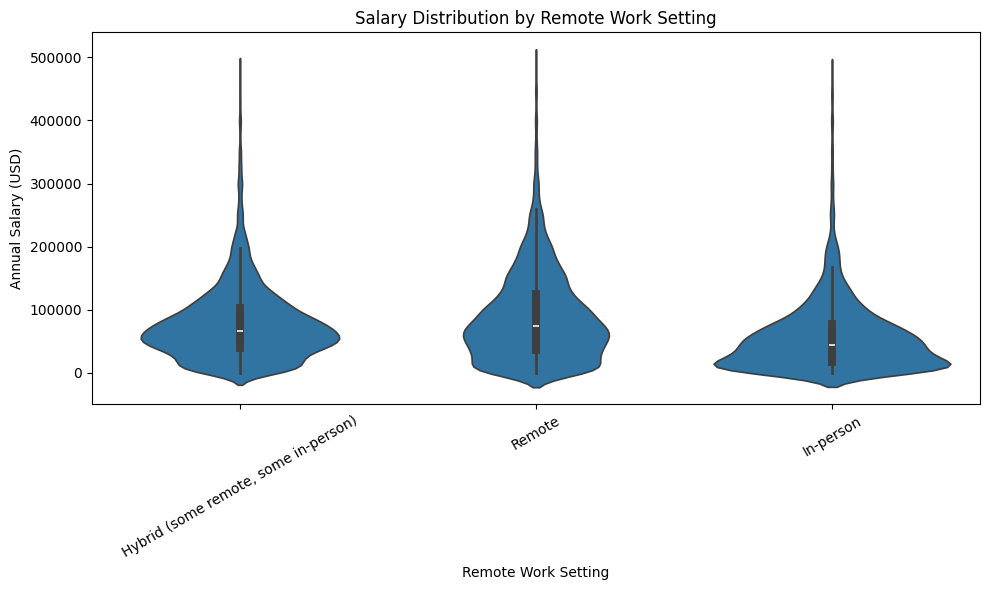

In [16]:
remote_salary = df[['RemoteWork', 'ConvertedCompYearly']].dropna()
remote_salary = remote_salary[remote_salary['ConvertedCompYearly'] < 500000]

plt.figure(figsize=(10,6))
sns.violinplot(x='RemoteWork', y='ConvertedCompYearly', data=remote_salary)
plt.xticks(rotation=30)
plt.title('Salary Distribution by Remote Work Setting')
plt.xlabel('Remote Work Setting')
plt.ylabel('Annual Salary (USD)')
plt.tight_layout()
plt.show()


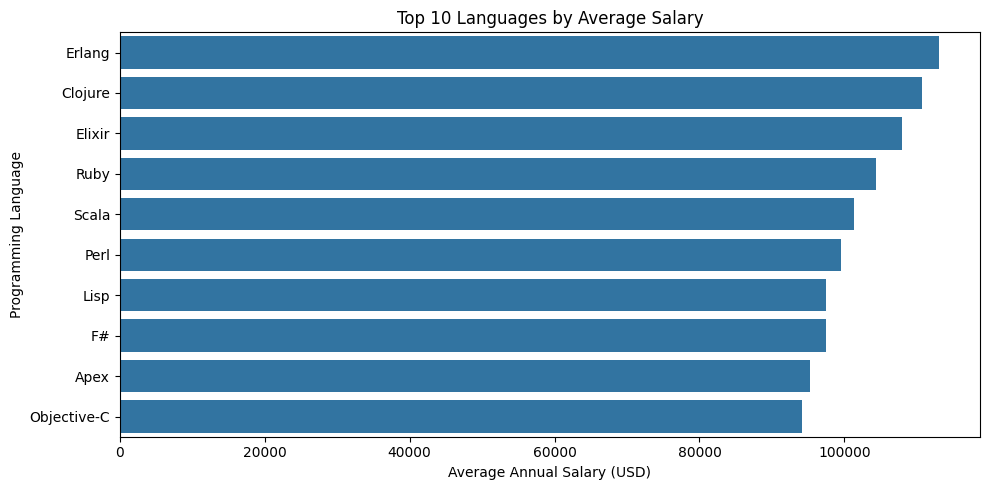

In [17]:
# Use LanguageHaveWorkedWith and salary
lang_salary = df[['LanguageHaveWorkedWith', 'ConvertedCompYearly']].dropna()
lang_salary = lang_salary[lang_salary['ConvertedCompYearly'] < 500000]

# Explode languages into separate rows
lang_salary = lang_salary.assign(Language=lang_salary['LanguageHaveWorkedWith'].str.split(';')).explode('Language')
lang_grouped = lang_salary.groupby('Language')['ConvertedCompYearly'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=lang_grouped.values, y=lang_grouped.index)
plt.title('Top 10 Languages by Average Salary')
plt.xlabel('Average Annual Salary (USD)')
plt.ylabel('Programming Language')
plt.tight_layout()
plt.show()

## **4. DATA CLEANING AND PREPARATION**
After conducting EDA, we identified missing values, inconsistent formats, and non-numeric data in key columns. Data cleaning is essential to ensure the dataset is complete, consistent, and suitable for modeling. It helps prevent errors, improves model accuracy, and ensures that the machine learning algorithms can correctly interpret and learn from the data.



In [18]:
# -------------------------------
# 3. Data Cleaning & Preparation
# -------------------------------
# Drop rows with missing key values
clean_df = eda_df.dropna(subset=['ConvertedCompYearly', 'YearsCodePro', 'EdLevel', 'Employment']).copy()

# Convert YearsCodePro to numeric
def convert_years_code(val):
    if val == 'Less than 1 year':
        return 0.5
    elif val == 'More than 50 years':
        return 51
    try:
        return float(val)
    except:
        return None

clean_df['YearsCodePro'] = clean_df['YearsCodePro'].apply(convert_years_code)
clean_df = clean_df.dropna(subset=['YearsCodePro'])

# Encode categorical variables
for col in ['EdLevel', 'Employment', 'RemoteWork', 'JobSat']:
    clean_df[col] = LabelEncoder().fit_transform(clean_df[col].astype(str))

# Define features and log-transformed target
features = ['EdLevel', 'Employment', 'RemoteWork', 'YearsCodePro']
X = clean_df[features]
y = clean_df['ConvertedCompYearly']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Summary of Cleaning:**

* Removed rows with missing salary or core features.

* Converted coding experience to numeric.

* Encoded categorical variables for modeling.

## **5. MODEL TRAINING AND EVALUATION**

In [19]:
# -------------------------------
# 4. Model Training & Evaluation
# -------------------------------
# Train model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", round(mae, 2))
print("R² Score:", round(r2, 4))

Mean Absolute Error: 50534.97
R² Score: 0.063


**Interpretation:**

* MAE ~ $50K: On average, the model is off by this much.

* R² ~ 0.06: The model explains ~6% of salary variation. Not strong — likely due to high salary variability and missing location/role-level features.

The model is basic but works as a proof-of-concept.
Further feature engineering (e.g., country, tech stack, industry) would improve accuracy.

## **6. Real-World Scenario and Prediction**

In [20]:
# -------------------------------
# 5. Salary Prediction (Sample Developer)
# -------------------------------
# Hypothetical developer input
sample = pd.DataFrame({
    'EdLevel': [2],         # Example: Master's degree
    'Employment': [0],      # Example: Full-time
    'RemoteWork': [1],      # Example: Hybrid
    'YearsCodePro': [3.0]   # 3 years of coding experience
})

predicted_salary = model.predict(sample)
print("Predicted Salary (USD):", predicted_salary[0])

Predicted Salary (USD): 68248.70698900489


**Interpretation:**

For a developer with a Master’s degree, 3 years of experience, and hybrid work, the model predicts a starting salary of ~$68000.
This provides a rough estimation to aid career planning or job negotiations.